First import useful packages

In [1]:
%matplotlib inline
import os
import glob
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator

from sklearn.model_selection  import ShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.ensemble import GradientBoostingRegressor   
import xgboost as xgb

C:\Users\Peter martigny\Anaconda3\envs\py35\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## I) Data Exploration (mostly from the starting kit)

#### Load data

In [2]:
data = pd.read_csv('train.csv')

y_df = data[['molecule', 'concentration']]
X_df = data.drop(['molecule', 'concentration'], axis=1)
spectra = X_df['spectra'].values                                        
spectra = np.array([np.array(dd[1:-1].split(',')).astype(float) for dd in spectra])    
X_df['spectra'] = spectra.tolist()

In [3]:
X_df.head()

,solute,spectra,vial
0,11,"[0.0152963, 0.0152944, 0.0153142, 0.0154096, 0...",1
1,1,"[0.0143634, 0.0143292, 0.0143999, 0.0145162, 0...",1
2,3,"[0.0163027, 0.0161848, 0.0163573, 0.0164119, 0...",1
3,10,"[0.0135833, 0.0135537, 0.0134438, 0.0136424, 0...",2
4,2,"[0.020811, 0.020767, 0.0208674, 0.0207018, 0.0...",3


In [4]:
# Repartition of molecules
y_df.molecule.value_counts()

R    260
B    259
A    243
Q    237
Name: molecule, dtype: int64

In [5]:
# Loading wavenumbers
freqs = pd.read_csv('freq.csv')
freqs = freqs['freqs'].values
print(freqs.shape, spectra.shape)

(1866,) (999, 1866)


In [6]:
freqs

array([  400.095,   402.626,   405.155, ...,  3996.41 ,  3997.88 ,  3999.36 ])

In [7]:
# Types of molecules
np.unique(y_df['molecule'].values)

array(['A', 'B', 'Q', 'R'], dtype=object)

In [8]:
# Target for classification
molecule = y_df['molecule'].values
# Target for regression
concentration = y_df['concentration'].values
# "Raw" features
X = spectra

### Some visualizations

#### Raman Spectra

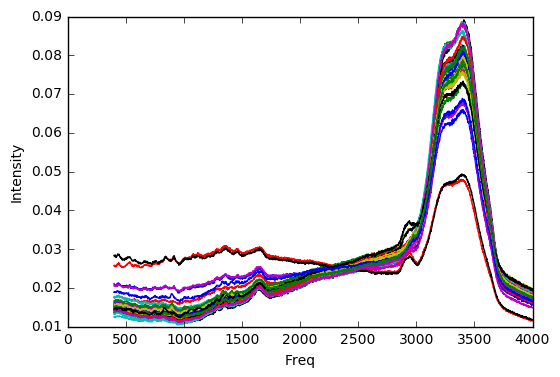

In [9]:
# Plot Raman spectra for all samples
plt.plot(freqs, spectra[100:130].T)
plt.xlabel('Freq')
plt.ylabel('Intensity')

#### Distribution of concentrations

There are 21 different values of concentrations.


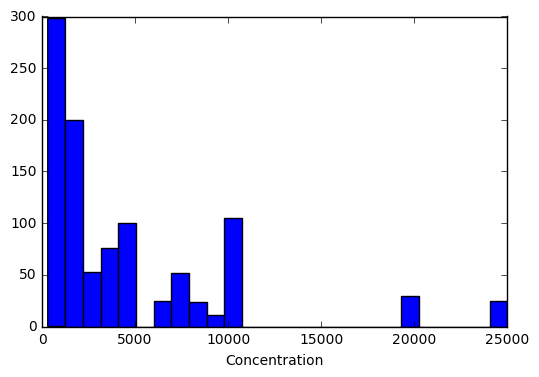

In [10]:
plt.hist(concentration, bins=26)
plt.xlabel('Concentration')
print("There are %s different values of concentrations." % np.unique(concentration).size)

Lots of samples have low concentrations. We notice that, because of the loss criteria considered in this task, error for low concentrations will be more important than errors for high concentrations!

[  300   400   600   800  1000  1400  1600  2000  5000 10000]
[  500  1000  1500  2000  4000  5000  7000 10000 20000 25000]
[ 1000  2000  3000  4000  5000  6000  7000  8000  9000 10000]
[  400   800  1000  1200  1600  2000  3000  4000  5000 10000]


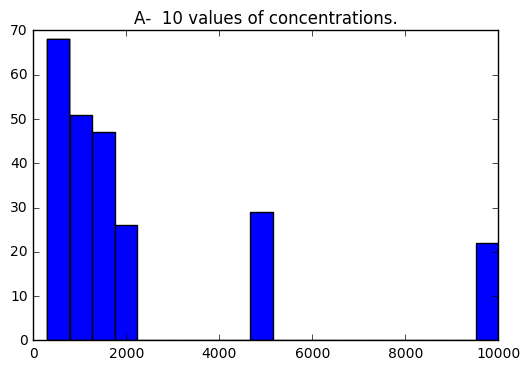

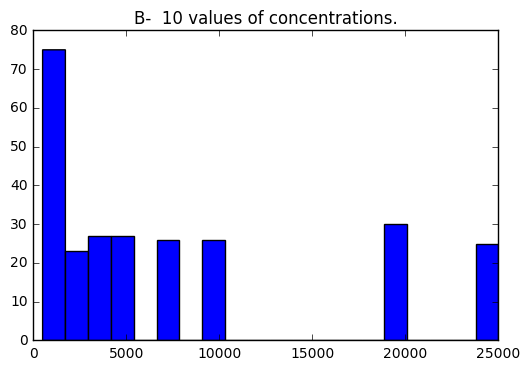

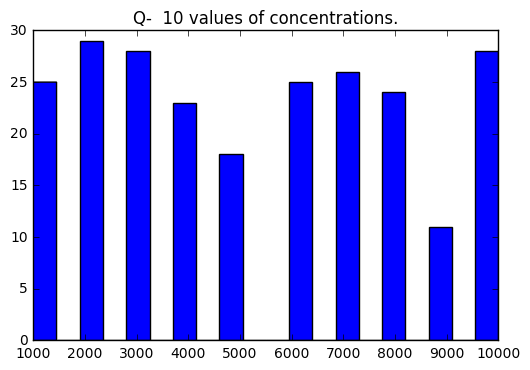

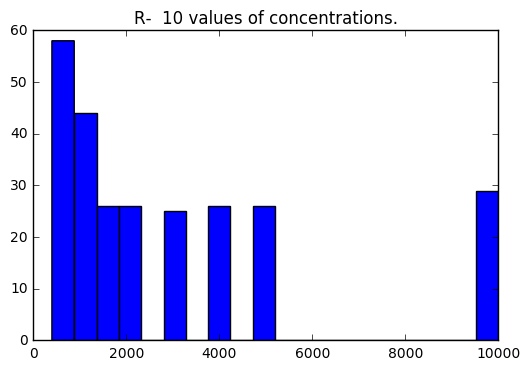

In [11]:
# Distribution of concentrations for each molecule

for mol in np.unique(molecule):
    plt.figure()
    plt.hist(concentration[molecule == mol], bins=20)
    plt.title(mol + "-  %s values of concentrations."
              % np.unique(concentration[molecule == mol]).size)
    print(np.unique(concentration[molecule == mol]))

Molecule Q has a uniform repartition of its concentration, whereas molecule A has mostly low concentrations.

#### Proportion of molecules

Number of samples: 999


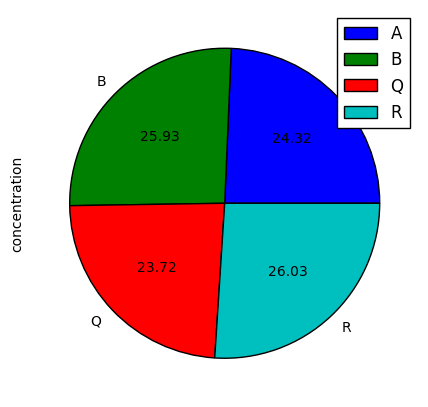

In [12]:
print('Number of samples: %s' % len(y_df))
y_df.groupby('molecule').count().plot(y='concentration', kind='pie', autopct='%.2f', figsize=(5, 5));

#### Proportion of solute groups and vial groups

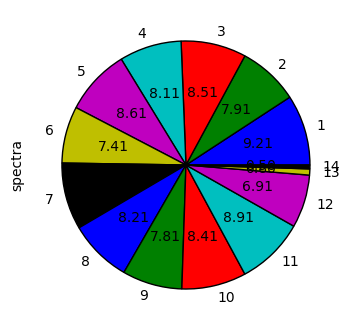

In [13]:
# Solute groups
X_df.groupby('solute').count().plot(y='spectra', kind='pie', autopct='%.2f', figsize=(4, 4), legend=None);

Group 7 is highly represented, whereas groups 13 and 14 are under represented.

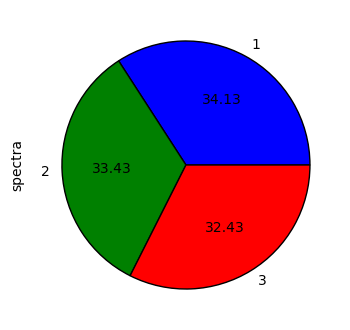

In [14]:
# Vial groups
X_df.groupby('vial').count().plot(y='spectra', kind='pie',  autopct='%.2f', figsize=(4, 4), legend=None)

The three groups are almost equally represented.

#### Mean Raman spectrum for each concentration

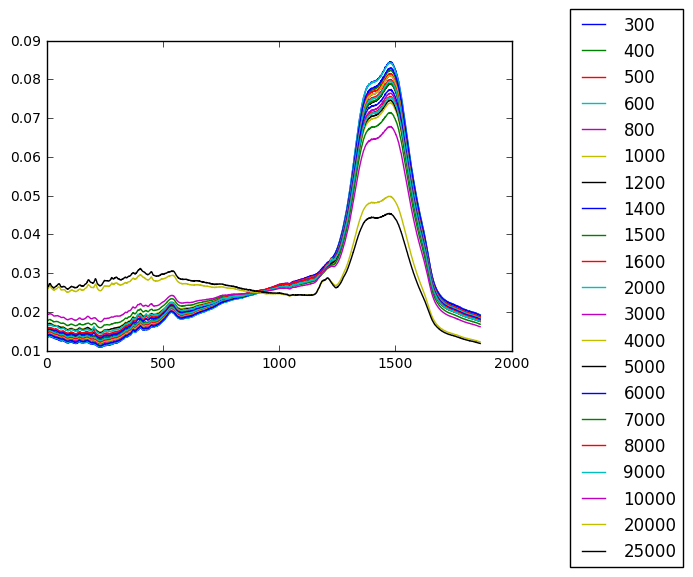

In [15]:
for c in np.unique(concentration):
    plt.plot(np.mean(X[concentration == c, :], axis=0), label="%s" % c)

plt.legend(bbox_to_anchor=(1.2, 1),
           bbox_transform=plt.gcf().transFigure);

Let's see the same result for only 10 concentrations

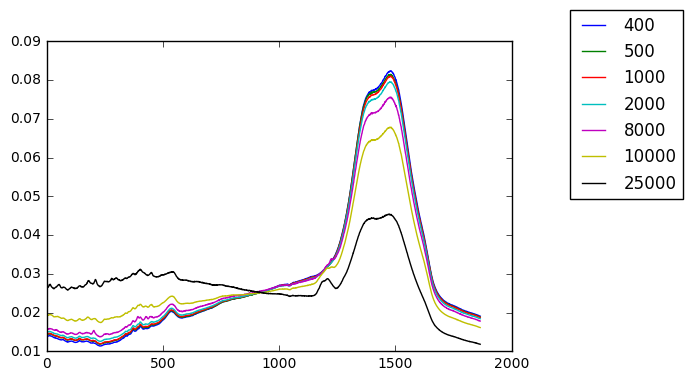

In [16]:
for c in np.unique(concentration[:10]):
    plt.plot(np.mean(X[concentration == c, :], axis=0), label="%s" % c)

plt.legend(bbox_to_anchor=(1.2, 1),
           bbox_transform=plt.gcf().transFigure);

Let's plot the spectra with log scale for y axis

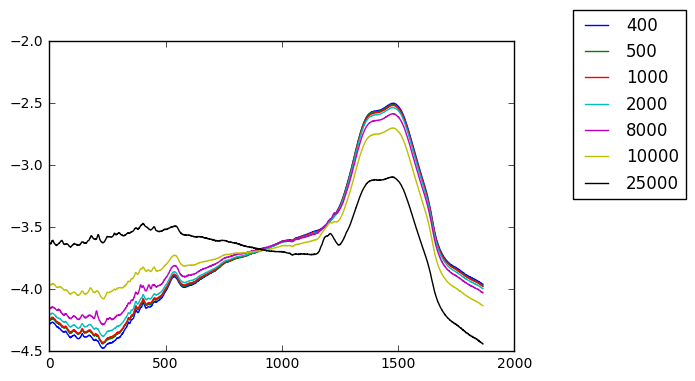

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for c in np.unique(concentration[:10]):
    plt.plot(np.mean(np.log(X[concentration == c, :]), axis=0), label="%s" % c)
#     ax.set_yscale('log')

plt.legend(bbox_to_anchor=(1.2, 1),
           bbox_transform=plt.gcf().transFigure);

We notice that, for the 2 highest concentrations, there is a particular behavior for smalll wavelenghts. This may be explained by a saturation. The peak intensity decreases with the concentration, which seems to be in contradiction with the theory.
There is a point, around 900, for which all spectra points before respect the rule (the hifger the concentration the higher the intensity) and all spectra points after do respect the opposite rule.
We also notice that the peak of intensity is almost the same for all the samples.

#### Mean Raman spectrum by molecule

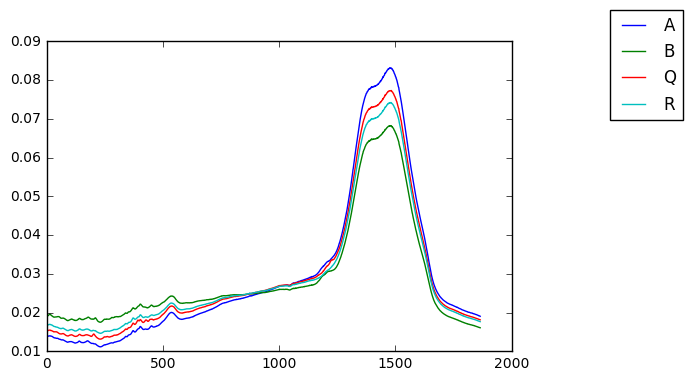

In [18]:
# Mean Raman spectra for each type of molecule
for mol in np.unique(molecule):
    plt.plot(np.mean(X[molecule == mol, :], axis=0), label="%s" % mol)

plt.legend(bbox_to_anchor=(1.2, 1),
           bbox_transform=plt.gcf().transFigure);

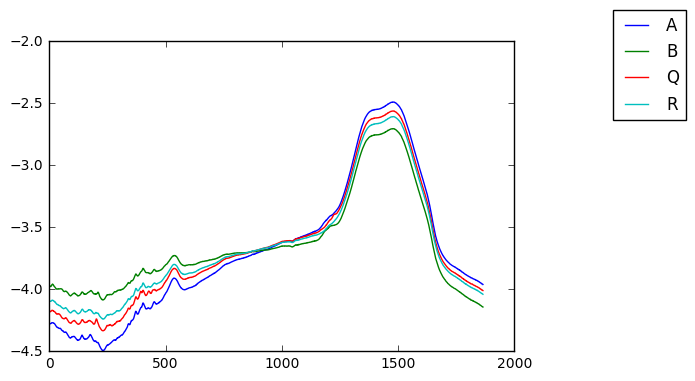

In [19]:
# Same plot after takinggg the logarithm of the concentrations
for mol in np.unique(molecule):
    plt.plot(np.mean(np.log(X[molecule == mol, :]), axis=0), label="%s" % mol)

plt.legend(bbox_to_anchor=(1.2, 1),
           bbox_transform=plt.gcf().transFigure);

The peak for molecule A is the ghest, then Q, R and B.
There is still an inversion point, as for the concentrations.

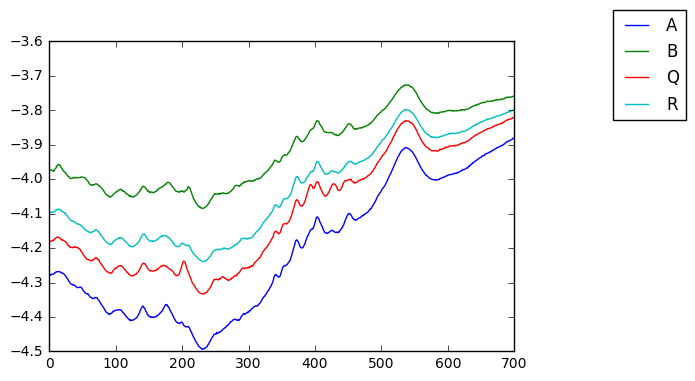

In [20]:
# Mean Raman spectra for each type of molecule before the inversion point
for mol in np.unique(molecule):
    plt.plot(np.mean(np.log(X[molecule == mol, :]), axis=0), label="%s" % mol)
    plt.xlim([0, 700])
    plt.ylim([-4.5, -3.6])
plt.legend(bbox_to_anchor=(1.2, 1),
           bbox_transform=plt.gcf().transFigure);

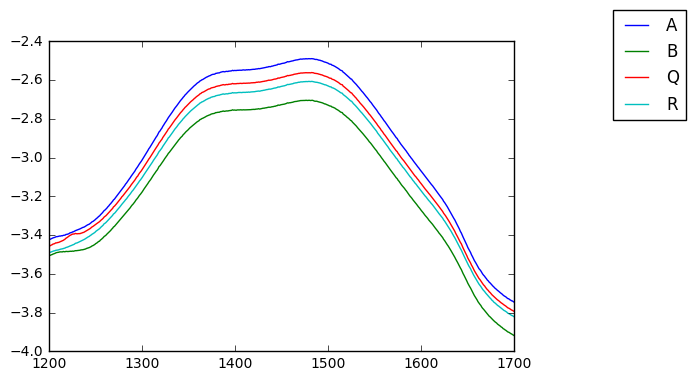

In [21]:
# Mean Raman spectra for each type of molecule after the inversion point
for mol in np.unique(molecule):
    plt.plot(np.mean(np.log(X[molecule == mol, :]), axis=0), label="%s" % mol)
    plt.xlim([1200, 1700])
    plt.ylim([-4, -2.4])
plt.legend(bbox_to_anchor=(1.2, 1),
           bbox_transform=plt.gcf().transFigure);

Hence, this will be interesting to build features: 
- minimum value of the spectrum before the inversion point
- maximum value of the spectrum after the inversion point

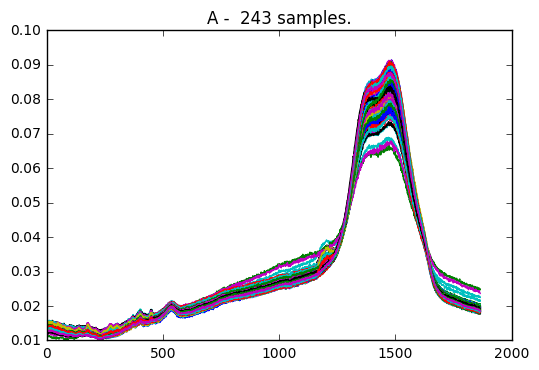

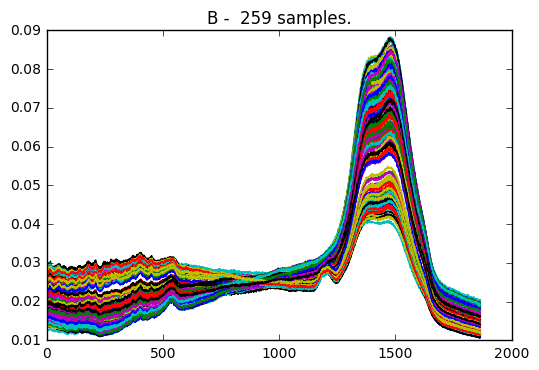

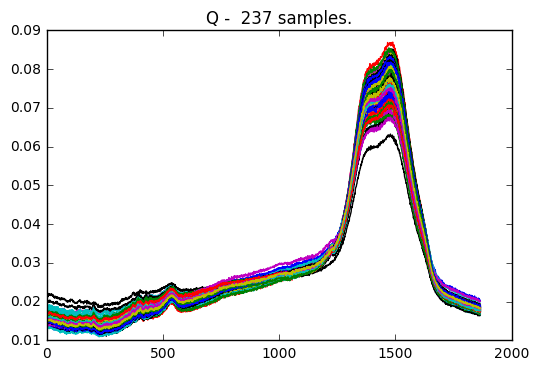

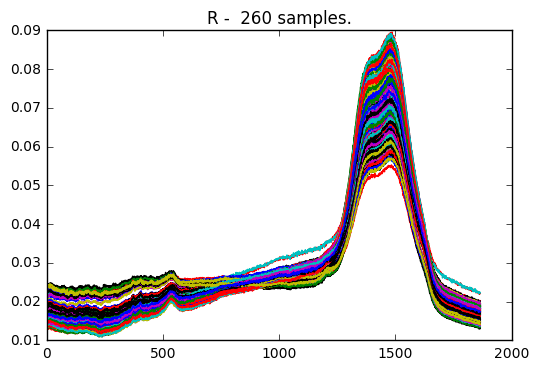

In [22]:
# For each molecule
for mol in np.unique(molecule):
    plt.figure()
    plt.plot(X[molecule == mol, :].T)
    plt.title(mol + " -  %s samples." % X[molecule == mol, :].shape[0]);

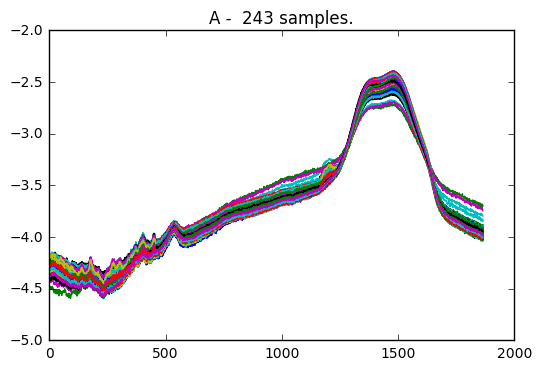

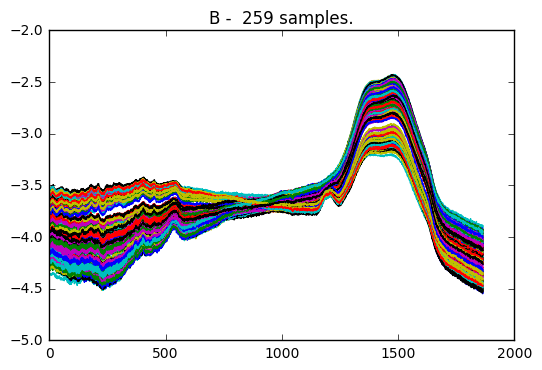

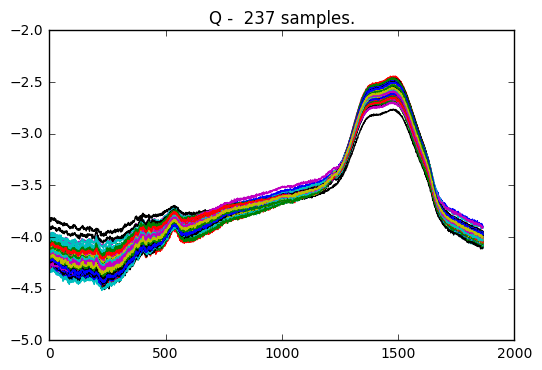

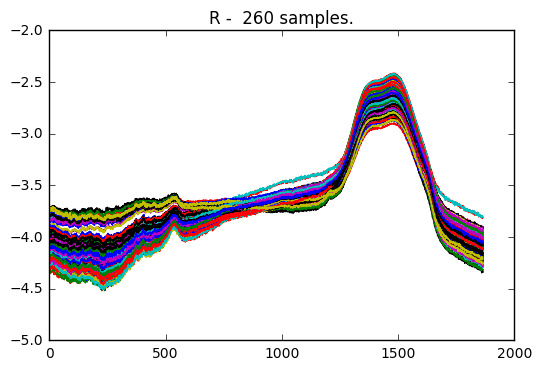

In [23]:
# For each molecule, same with the logarithm of the concentrations
for mol in np.unique(molecule):
    plt.figure()
    plt.plot(np.log(X[molecule == mol, :].T))
    plt.title(mol + " -  %s samples." % X[molecule == mol, :].shape[0]);

## II) Classification

## Starting Kit
#### Feature extractor for classification

In [24]:
import numpy as np
import pandas as pd

class FeatureExtractorClf(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_df):
        pass
    
    def transform(self, X_df):
        XX = np.array([np.array(dd) for dd in X_df['spectra']]) # Take the raw spectrum
#         XX = np.concatenate((XX, X_df.solute.reshape(X_df.shape[0], 1)), 1)
#         XX = np.concatenate((XX, X_df.vial.reshape(X_df.shape[0], 1)), 1)
        return XX

#### Classifier

In [25]:
class Classifier(BaseEstimator):
    def __init__(self):
        self.n_components = 100
        self.n_estimators = 300
        self.clf = Pipeline([
            ('pca', PCA(n_components=self.n_components)), 
            ('clf', RandomForestClassifier(n_estimators=self.n_estimators, random_state=42))
        ])

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

Let's test the pipeline

In [26]:
labels = np.array(['A', 'B', 'Q', 'R'])

def train_test_model_clf(X_df, y_df, skf_is, FeatureExtractor, Classifier):
    train_is, test_is = skf_is
    X_train_df = X_df.iloc[train_is].copy()                                  
    y_train_df = y_df.iloc[train_is].copy()
    y_train_clf = y_train_df['molecule'].values
    X_test_df = X_df.iloc[test_is].copy()                                    
    y_test_df = y_df.iloc[test_is].copy() 
    y_test_clf = y_test_df['molecule'].values 
    # Feature extraction
    fe_clf = FeatureExtractor()
    fe_clf.fit(X_train_df, y_train_df)
    X_train_array_clf = fe_clf.transform(X_train_df)
    X_test_array_clf = fe_clf.transform(X_test_df)
    # Train
    clf = Classifier()
    clf.fit(X_train_array_clf, y_train_clf)
    # Test 
    y_proba_clf = clf.predict_proba(X_test_array_clf)                        
    y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
    error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
    print('error = %s' % error)                                                                            
    print('classification report:\n %s' % classification_report(y_test_clf, y_pred_clf))
    print('confusion matrix:\n %s' % confusion_matrix(y_test_clf, y_pred_clf))


skf = ShuffleSplit(n_splits =2, test_size=0.2, random_state=57)  
skf_is = list(skf.split(X_df))[0]

train_test_model_clf(X_df, y_df, skf_is, FeatureExtractorClf, Classifier)

error = 0.105
classification report:
              precision    recall  f1-score   support

          A       0.88      0.90      0.89        63
          B       0.83      0.89      0.86        45
          Q       0.97      0.90      0.94        40
          R       0.92      0.88      0.90        52

avg / total       0.90      0.90      0.90       200

confusion matrix:
 [[57  4  1  1]
 [ 2 40  0  3]
 [ 3  1 36  0]
 [ 3  3  0 46]]


## Custom Methods

#### Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

labels = np.array(['A', 'B', 'Q', 'R'])

# Samples the train test split
skf = ShuffleSplit(n_splits =2, test_size=0.2, random_state=57)  
skf_is = list(skf.split(X_df))[0]

train_is, test_is = skf_is
X_train_df = X_df.iloc[train_is].copy()                                  
y_train_df = y_df.iloc[train_is].copy()
y_train_clf = y_train_df['molecule'].values
X_test_df = X_df.iloc[test_is].copy()                                    
y_test_df = y_df.iloc[test_is].copy() 
y_test_clf = y_test_df['molecule'].values 
# Feature extraction
fe_clf = FeatureExtractorClf()
fe_clf.fit(X_train_df, y_train_df)
X_train_array_clf = fe_clf.transform(X_train_df)
X_test_array_clf = fe_clf.transform(X_test_df)

# Train
pca = PCA(n_components=100)
pca.fit(X_train_array_clf)
X_train_array_clf = pca.transform(X_train_array_clf)
clf = LogisticRegression(penalty='l1', random_state=42, C = 200)
clf.fit(X_train_array_clf, y_train_clf)

# Test 
X_test_array_clf = pca.transform(X_test_array_clf)
y_proba_clf = clf.predict_proba(X_test_array_clf)                        
y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
print('error = %s' % error)  

error = 0.02


In [107]:
labels = np.array(['A', 'B', 'Q', 'R'])

def train_test_model_clf(X_df, y_df, skf_is, FeatureExtractor, Classifier):
    train_is, test_is = skf_is
    X_train_df = X_df.iloc[train_is].copy()                                  
    y_train_df = y_df.iloc[train_is].copy()
    y_train_clf = y_train_df['molecule'].values
    X_test_df = X_df.iloc[test_is].copy()                                    
    y_test_df = y_df.iloc[test_is].copy() 
    y_test_clf = y_test_df['molecule'].values 
    # Feature extraction
    fe_clf = FeatureExtractor()
    fe_clf.fit(X_train_df, y_train_df)
    X_train_array_clf = fe_clf.transform(X_train_df)
    X_test_array_clf = fe_clf.transform(X_test_df)
    # Train
    clf = Classifier()
    clf.fit(X_train_array_clf, y_train_clf)
    # Test 
    y_proba_clf = clf.predict_proba(X_test_array_clf)                        
    y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
    error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
    print('error = %s' % error)                                                                            
    print('classification report:\n %s' % classification_report(y_test_clf, y_pred_clf))
    print('confusion matrix:\n %s' % confusion_matrix(y_test_clf, y_pred_clf))


class Classifier(BaseEstimator):
    def __init__(self):
        self.n_components = 100
        self.penalty = 'l2'
        self.C = 50000
        self.solver = 'lbfgs'
        self.clf = Pipeline([
            ('pca', PCA(n_components=self.n_components)), 
            ('clf', LogisticRegression(penalty=self.penalty, 
                                       C = self.C, 
                                       random_state=42,
                                      solver=self.solver))
        ])

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


    
skf = ShuffleSplit(n_splits =2, test_size=0.2)  
skf_is = list(skf.split(X_df))[0]

train_test_model_clf(X_df, y_df, skf_is, FeatureExtractorClf, Classifier)

error = 0.075
classification report:
              precision    recall  f1-score   support

          A       0.91      0.98      0.94        52
          B       0.98      0.81      0.89        53
          Q       1.00      0.92      0.96        51
          R       0.83      1.00      0.91        44

avg / total       0.93      0.93      0.92       200

confusion matrix:
 [[51  1  0  0]
 [ 2 43  0  8]
 [ 3  0 47  1]
 [ 0  0  0 44]]


GridSearch Cross Validation

In [29]:
labels = np.array(['A', 'B', 'Q', 'R'])

# Samples the train test split
skf = ShuffleSplit(n_splits =2, test_size=0.2, random_state=57)  
skf_is = list(skf.split(X_df))[0]

train_is, test_is = skf_is
X_train_df = X_df.iloc[train_is].copy()                                  
y_train_df = y_df.iloc[train_is].copy()
y_train_clf = y_train_df['molecule'].values
X_test_df = X_df.iloc[test_is].copy()                                    
y_test_df = y_df.iloc[test_is].copy() 
y_test_clf = y_test_df['molecule'].values 
# Feature extraction
fe_clf = FeatureExtractorClf()
fe_clf.fit(X_train_df, y_train_df)
X_train_array_clf = fe_clf.transform(X_train_df)
X_test_array_clf = fe_clf.transform(X_test_df)

# Train
pca = PCA(n_components=100)
pca.fit(X_train_array_clf)
X_train_array_clf = pca.transform(X_train_array_clf)
clf = LogisticRegression(penalty='l1', random_state=42, C = 200)
clf.fit(X_train_array_clf, y_train_clf)

# Test 
X_test_array_clf = pca.transform(X_test_array_clf)
y_proba_clf = clf.predict_proba(X_test_array_clf)                        
y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
print('error = %s' % error) 


# y_reg = y_df['concentration'].astype(float)
# y_reg

pipe = Pipeline([
        ('pca', PCA()),
        ('clf', LogisticRegression(random_state=42, learning_rate=0.2))
    ])
params = dict(pca__n_components=[50, 100],
             clf__penalty=['l1', 'l2'],
             clf__C = [100, 200])

clf = GridSearchCV(pipe, param_grid=params, cv=10, n_jobs=5)
clf.fit(X_train_array_reg, y_train_reg.astype(float))

error = 0.02


TypeError: __init__() got an unexpected keyword argument 'learning_rate'

#### SVM

In [173]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import VotingClassifier
labels = np.array(['A', 'B', 'Q', 'R'])

# Samples the train test split
skf = ShuffleSplit(n_splits =2, test_size=0.2)  
skf_is = list(skf.split(X_df))[0]

train_is, test_is = skf_is
X_train_df = X_df.iloc[train_is].copy()                                  
y_train_df = y_df.iloc[train_is].copy()
y_train_clf = y_train_df['molecule'].values
X_test_df = X_df.iloc[test_is].copy()                                    
y_test_df = y_df.iloc[test_is].copy() 
y_test_clf = y_test_df['molecule'].values 
# Feature extraction
fe_clf = FeatureExtractorClf()
fe_clf.fit(X_train_df, y_train_df)
X_train_array_clf = fe_clf.transform(X_train_df)
X_test_array_clf = fe_clf.transform(X_test_df)


# y_train_clf

# Train
pca = PCA(n_components=100)
pca.fit(X_train_array_clf)
X_train_array_clf = pca.transform(X_train_array_clf)
# SVM
clf_svm = svm.SVC(random_state=42, probability=True, C = 30000, gamma = 1)
clf_svm.fit(X_train_array_clf, y_train_clf)
# LOoistic regression
clf_log = LogisticRegression(penalty='l1', C=200)
clf_log.fit(X_train_array_clf, y_train_clf)

# Test 
X_test_array_clf = pca.transform(X_test_array_clf)

y_proba_clf_svm = clf_svm.predict_proba(X_test_array_clf)                        
y_proba_clf_log = clf_log.predict_proba(X_test_array_clf)                        


y_pred_clf_svm = labels[np.argmax(y_proba_clf_svm, axis=1)]                      
error_svm = 1 - accuracy_score(y_test_clf, y_pred_clf_svm)                       
print('error = %s' % error_svm)  
y_pred_clf_log = labels[np.argmax(y_proba_clf_log, axis=1)]                      
error_log = 1 - accuracy_score(y_test_clf, y_pred_clf_log)                       
print('error = %s' % error_log)  


# Voting classifier
eclf = VotingClassifier(estimators=[
        ('svm', clf_svm), ('log', clf_log)], voting='soft')
eclf.fit(X_train_array_clf, y_train_clf)
y_proba_clf_ens = eclf.predict_proba(X_test_array_clf)                        
y_pred_clf_ens = labels[np.argmax(y_proba_clf_ens, axis=1)]                      
error_ens = 1 - accuracy_score(y_test_clf, y_pred_clf_ens)                       
print('error = %s' % error_ens)

error = 0.025
error = 0.025
error = 0.025


In [ ]:
class Classifier(BaseEstimator):
    def __init__(self):
        self.n_components = 100
        self.C = 30000
        self.gamma = 1
        self.clf = Pipeline([
            ('pca', PCA(n_components=self.n_components)), 
            ('clf', svm.SVC(probability=True, C = self.C, gamma = self.gamma))
        ])

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)
    
train_test_model_clf(X_df, y_df, skf_is, FeatureExtractorClf, Classifier)

In [168]:
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

skf = ShuffleSplit(n_splits =2, test_size=0.2)  
skf_is = list(skf.split(X_df))[0]

class Classifier(BaseEstimator):
    def __init__(self):
        self.n_components = 100
        self.C = 30000
        self.gamma = 1
        self.clf = Pipeline([
            ('pca', PCA(n_components=self.n_components)), 
            ('clf', VotingClassifier(estimators=[
        ('svm', svm.SVC(random_state=42, probability=True, C = 30000, gamma = 1)), ('log', LogisticRegression(penalty='l1', C=200))], voting='soft'))
        ])

    def fit(self, X, y):
        self.clf.fit(X, y)

    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)
    
train_test_model_clf(X_df, y_df, skf_is, FeatureExtractorClf, Classifier)

error = 0.025
classification report:
              precision    recall  f1-score   support

          A       1.00      0.98      0.99        45
          B       0.98      0.93      0.95        57
          Q       0.98      1.00      0.99        44
          R       0.95      1.00      0.97        54

avg / total       0.98      0.97      0.97       200

confusion matrix:
 [[44  1  0  0]
 [ 0 53  1  3]
 [ 0  0 44  0]
 [ 0  0  0 54]]


#### KNN

In [45]:
from sklearn.neighbors import KNeighborsClassifier
labels = np.array(['A', 'B', 'Q', 'R'])

# Samples the train test split
skf = ShuffleSplit(n_splits =2, test_size=0.2, random_state=57)  
skf_is = list(skf.split(X_df))[0]

train_is, test_is = skf_is
X_train_df = X_df.iloc[train_is].copy()                                  
y_train_df = y_df.iloc[train_is].copy()
y_train_clf = y_train_df['molecule'].values
X_test_df = X_df.iloc[test_is].copy()                                    
y_test_df = y_df.iloc[test_is].copy() 
y_test_clf = y_test_df['molecule'].values 
# Feature extraction
fe_clf = FeatureExtractorClf()
fe_clf.fit(X_train_df, y_train_df)
X_train_array_clf = fe_clf.transform(X_train_df)
X_test_array_clf = fe_clf.transform(X_test_df)


# y_train_clf

# Train
pca = PCA(n_components=100)
pca.fit(X_train_array_clf)
X_train_array_clf = pca.transform(X_train_array_clf)
clf = KNeighborsClassifier(n_neighbors=3, weights='distance')
clf.fit(X_train_array_clf, y_train_clf)

# Test 
X_test_array_clf = pca.transform(X_test_array_clf)
y_proba_clf = clf.predict_proba(X_test_array_clf)                        
y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
print('error = %s' % error)  

error = 0.185


The KNN algorithm gives bad results compared with the logistic regression or SVM.

For the classification, we consider the 0/1 loss so here we have an error of 0.1. This will be our baseline to be optimized.

#### Neural Networks

In [46]:
from sklearn.neural_network import MLPClassifier

In [149]:
# Samples the train test split
skf = ShuffleSplit(n_splits =2, test_size=0.2)  
skf_is = list(skf.split(X_df))[0]

train_is, test_is = skf_is
X_train_df = X_df.iloc[train_is].copy()                                  
y_train_df = y_df.iloc[train_is].copy()
y_train_clf = y_train_df['molecule'].values
X_test_df = X_df.iloc[test_is].copy()                                    
y_test_df = y_df.iloc[test_is].copy() 
y_test_clf = y_test_df['molecule'].values 
# Feature extraction
fe_clf = FeatureExtractorClf()
fe_clf.fit(X_train_df, y_train_df)
X_train_array_clf = fe_clf.transform(X_train_df)
X_test_array_clf = fe_clf.transform(X_test_df)


# y_train_clf

# Train
pca = PCA(n_components=100)
pca.fit(X_train_array_clf)
X_train_array_clf = pca.transform(X_train_array_clf)
clf = MLPClassifier(solver='lbfgs', alpha=0.005,
                    hidden_layer_sizes=(100),
                   activation = 'logistic',
                   learning_rate = 'adaptive',
                   max_iter = 400)
clf.fit(X_train_array_clf, y_train_clf)

# Test 
X_test_array_clf = pca.transform(X_test_array_clf)
y_proba_clf = clf.predict_proba(X_test_array_clf)                        
y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
print('error = %s' % error)  

error = 0.09


## III) Regression
#### Starting kit

#### Feature extraction for regression

In [52]:
labels = np.array(['A', 'B', 'Q', 'R'])

class FeatureExtractorReg(object):
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass
    
    def transform(self, X_df):                                                   
        XX = np.array([np.array(dd) for dd in X_df['spectra']])                  
        XX -= np.median(XX, axis=1)[:, None]                                     
        XX /= np.sqrt(np.sum(XX ** 2, axis=1))[:, None]                          
        XX = np.concatenate([XX, X_df[labels].values], axis=1)                   
        return XX   

Here, the transform part is a normalization

#### Regressor

In [53]:
class Regressor(BaseEstimator):                                                  
    def __init__(self):                                                          
        self.n_components = 100                                                  
        self.n_estimators = 40                                                   
        self.learning_rate = 0.2                                                 
        self.list_molecule = ['A', 'B', 'Q', 'R']                                
        self.dict_reg = {}                                                       
        for mol in self.list_molecule:                                           
            self.dict_reg[mol] = Pipeline([                                      
                ('pca', PCA(n_components=self.n_components)),                    
                ('reg', GradientBoostingRegressor(                               
                    n_estimators=self.n_estimators,                              
                    learning_rate=self.learning_rate,                            
                    random_state=42))                                            
            ])                                                                 
                                                                                 
    def fit(self, X, y):                                                         
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol]                                                  
            y_mol = y[ind_mol].astype(float)                                     
            self.dict_reg[mol].fit(XX_mol, np.log(y_mol))                        
                                                                                 
    def predict(self, X):                                                        
        y_pred = np.zeros(X.shape[0])                                            
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol].astype(float)                                    
            y_pred[ind_mol] = np.exp(self.dict_reg[mol].predict(XX_mol))         
        return y_pred    

#### All together

In [54]:
def mare_score(y_true, y_pred):                                                  
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

def train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor):
    train_is, test_is = skf_is
    X_train_df = X_df.iloc[train_is].copy()                                  
    y_train_df = y_df.iloc[train_is].copy()                                  
    X_test_df = X_df.iloc[test_is].copy()                                    
    y_test_df = y_df.iloc[test_is].copy()                                    
    y_train_clf = y_train_df['molecule'].values                              
    y_train_reg = y_train_df['concentration'].values                         
    y_test_clf = y_test_df['molecule'].values                                
    y_test_reg = y_test_df['concentration'].values                           

    # Classification
    fe_clf = FeatureExtractorClf()                     
    fe_clf.fit(X_train_df, y_train_df)                                       
    X_train_array_clf = fe_clf.transform(X_train_df)                         
    X_test_array_clf = fe_clf.transform(X_test_df)                           
                                                                                 
    clf = Classifier()                                            
    clf.fit(X_train_array_clf, y_train_clf)                                  
    y_proba_clf = clf.predict_proba(X_test_array_clf)                        
    y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
    error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
    print('error = ', error)
    
    # Regression
    fe_reg = FeatureExtractorReg()                     
    for i, label in enumerate(labels):
        # For training, we use 
        X_train_df.loc[:, label] = (y_train_df['molecule'] == label)         
        X_test_df.loc[:, label] = y_proba_clf[:, i]                          
    fe_reg.fit(X_train_df, y_train_reg)                                      
    X_train_array_reg = fe_reg.transform(X_train_df)                         
    X_test_array_reg = fe_reg.transform(X_test_df)                           
                                                                                 
    reg = Regressor()                                              
    reg.fit(X_train_array_reg, y_train_reg)                               
    y_pred_reg = reg.predict(X_test_array_reg)
    mare = mare_score(y_test_reg, y_pred_reg)
    print('mare = ', mare)                
    print('combined error = ', 2. / 3 * error + 1. / 3 * mare)


skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=57) 
skf_is = list(skf.split(X_df))[0]

train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor)

error =  0.02
mare =  0.198847041755
combined error =  0.0796156805851


## Custom methods

#### Gradient Boosting with parameters tuning

In [55]:
class Regressor(BaseEstimator):                                                  
    def __init__(self):                                                          
        self.n_components = 50
        self.n_estimators = 40                                                   
        self.learning_rate = 0.3                                      
        self.list_molecule = ['A', 'B', 'Q', 'R']                                
        self.dict_reg = {}        
        self.loss = 'ls'
        for mol in self.list_molecule:                                           
            self.dict_reg[mol] = Pipeline([                                      
                ('pca', PCA(n_components=self.n_components)),                    
                ('reg', GradientBoostingRegressor(                               
                    n_estimators=self.n_estimators,                              
                    learning_rate=self.learning_rate,                            
                    random_state=42, loss = self.loss))                                            
            ])                                                                 
                                                                                 
    def fit(self, X, y):                                                         
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol]                                                  
            y_mol = y[ind_mol].astype(float)                                     
            self.dict_reg[mol].fit(XX_mol, np.log(y_mol))                        
                                                                                 
    def predict(self, X):                                                        
        y_pred = np.zeros(X.shape[0])                                            
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol].astype(float)                                    
            y_pred[ind_mol] = np.exp(self.dict_reg[mol].predict(XX_mol))         
        return y_pred 
    
skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=57) 
skf_is = list(skf.split(X_df))[0]

train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor)

error =  0.025
mare =  0.189089551842
combined error =  0.0796965172807


#### Support Vector Regression (SVR)

In [56]:
from sklearn.svm import SVR

class FeatureExtractorReg(object):
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass
    
    def transform(self, X_df):                                                   
        XX = np.array([np.array(dd) for dd in X_df['spectra']])                  
        XX -= np.median(XX, axis=1)[:, None]                                     
        XX /= np.sqrt(np.sum(XX ** 2, axis=1))[:, None]                          
        XX = np.concatenate([XX, X_df[labels].values], axis=1)                   
        return XX  


class Regressor(BaseEstimator):                                                  
    def __init__(self):                                                          
        self.n_components = 50
        self.C = 100000
        self.epsilon = 0.2
        self.gamma = 50
        self.kernel = 'rbf'
                                    
        self.list_molecule = ['A', 'B', 'Q', 'R']                                
        self.dict_reg = {}        

        for mol in self.list_molecule:                                           
            self.dict_reg[mol] = Pipeline([                                      
                ('pca', PCA(n_components=self.n_components)),                    
                ('reg', SVR(C = self.C, 
                            epsilon = self.epsilon, 
                            gamma = self.gamma,
                           kernel = self.kernel))                                            
            ])                                                                 
                                                                                 
    def fit(self, X, y):                                                         
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol]                                                  
            y_mol = y[ind_mol].astype(float)                                     
            self.dict_reg[mol].fit(XX_mol, np.log(y_mol))                        
                                                                                 
    def predict(self, X):                                                        
        y_pred = np.zeros(X.shape[0])                                            
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol].astype(float)                                    
            y_pred[ind_mol] = np.exp(self.dict_reg[mol].predict(XX_mol))         
        return y_pred 
    
skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=57) 
skf_is = list(skf.split(X_df))[0]

train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor)

error =  0.025
mare =  0.173907823674
combined error =  0.0746359412248


#### Material for submission first_push (may be better with C = 30 000 and gamma = 1

In [57]:
# # Feature extractor for classification
# import numpy as np
# # import pandas as pd


# class FeatureExtractorClf():
#     def __init__(self):
#         pass

#     def fit(self, X_df, y):
#         pass

#     def transform(self, X_df):
#         XX = np.array([np.array(dd) for dd in X_df['spectra']])
#         return XX
    
# # Classifier

# from sklearn.linear_model import LogisticRegression
# from sklearn.decomposition import PCA
# from sklearn.pipeline import Pipeline
# from sklearn.base import BaseEstimator


# class Classifier(BaseEstimator):
#     def __init__(self):
#         self.n_components = 100
#         self.penalty = 'l1'
#         self.C = 200
#         self.clf = Pipeline([
#             ('pca', PCA(n_components=self.n_components)), 
#             ('clf', LogisticRegression(penalty=self.penalty, C = self.C, random_state=42))
#         ])

#     def fit(self, X, y):
#         self.clf.fit(X, y)

#     def predict(self, X):
#         return self.clf.predict(X)

#     def predict_proba(self, X):
#         return self.clf.predict_proba(X)
    
# # Feature extractor for regression
# import numpy as np
# # import pandas as pd


# labels = np.array(['A', 'B', 'Q', 'R'])

# class FeatureExtractorReg():
#     def __init__(self):
#         pass

#     def fit(self, X_df, y):
#         pass

#     def transform(self, X_df):
#         XX = np.array([np.array(dd) for dd in X_df['spectra']])
#         XX -= np.median(XX, axis=1)[:, None]
#         XX /= np.sqrt(np.sum(XX ** 2, axis=1))[:, None]
#         XX = np.concatenate([XX, X_df[labels].values], axis=1)
#         return XX
    
# # Regressor
# from sklearn.svm import SVR
# from sklearn.decomposition import PCA
# from sklearn.pipeline import Pipeline
# from sklearn.base import BaseEstimator
# import numpy as np


# class Regressor(BaseEstimator):                                                  
#     def __init__(self):                                                          
#         self.n_components = 50
#         self.C = 100000
#         self.epsilon = 0.2
#         self.gamma = 50
#         self.kernel = 'rbf'
                                    
#         self.list_molecule = ['A', 'B', 'Q', 'R']                                
#         self.dict_reg = {}        

#         for mol in self.list_molecule:                                           
#             self.dict_reg[mol] = Pipeline([                                      
#                 ('pca', PCA(n_components=self.n_components)),                    
#                 ('reg', SVR(C = self.C, 
#                             epsilon = self.epsilon, 
#                             gamma = self.gamma,
#                            kernel = self.kernel))                                            
#             ])                                                                 
                                                                                 
#     def fit(self, X, y):                                                         
#         for i, mol in enumerate(self.list_molecule):                             
#             ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
#             XX_mol = X[ind_mol]                                                  
#             y_mol = y[ind_mol].astype(float)                                     
#             self.dict_reg[mol].fit(XX_mol, np.log(y_mol))                        
                                                                                 
#     def predict(self, X):                                                        
#         y_pred = np.zeros(X.shape[0])                                            
#         for i, mol in enumerate(self.list_molecule):                             
#             ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
#             XX_mol = X[ind_mol].astype(float)                                    
#             y_pred[ind_mol] = np.exp(self.dict_reg[mol].predict(XX_mol))         
#         return y_pred 

Can we do better by predicting the log of the concentration instead of the concentration itself?

In [58]:
y_dg = y_df.copy()
y_dg['concentration'] = np.log(y_dg['concentration'].astype(float))
y_dg.head()

,molecule,concentration
0,Q,8.987197
1,B,6.214608
2,B,7.600902
3,A,7.600902
4,B,9.210340


In [59]:
skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=57) 
skf_is = list(skf.split(X_df))[0]

train_test_model(X_df, y_dg, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor)

error =  0.025
mare =  0.102421473592
combined error =  0.0508071578642


In [60]:
class FeatureExtractorReg(object):
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass
    
    def transform(self, X_df):                                                   
        XX = np.array([np.array(dd) for dd in X_df['spectra']])                  
        XX -= np.median(XX, axis=1)[:, None]                                     
        XX /= np.sqrt(np.sum(XX ** 2, axis=1))[:, None]                          
        XX = np.concatenate([XX, X_df[labels].values], axis=1)                   
        return XX   
    
def train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor):
    train_is, test_is = skf_is
    X_train_df = X_df.iloc[train_is].copy()                                  
    y_train_df = y_df.iloc[train_is].copy()                                  
    X_test_df = X_df.iloc[test_is].copy()                                    
    y_test_df = y_df.iloc[test_is].copy()                                    
    y_train_clf = y_train_df['molecule'].values                              
    y_train_reg = y_train_df['concentration'].values                         
    y_test_clf = y_test_df['molecule'].values                                
    y_test_reg = y_test_df['concentration'].values                           

    # Classification
    fe_clf = FeatureExtractorClf()                     
    fe_clf.fit(X_train_df, y_train_df)                                       
    X_train_array_clf = fe_clf.transform(X_train_df)                         
    X_test_array_clf = fe_clf.transform(X_test_df)                           
                                                                                 
    clf = Classifier()                                            
    clf.fit(X_train_array_clf, y_train_clf)                                  
    y_proba_clf = clf.predict_proba(X_test_array_clf)                        
    y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
    error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
    print('error = ', error)
    
    # Regression
    fe_reg = FeatureExtractorReg()                     
    for i, label in enumerate(labels):
        # For training, we use 
        X_train_df.loc[:, label] = (y_train_df['molecule'] == label)         
        X_test_df.loc[:, label] = y_proba_clf[:, i]                          
    fe_reg.fit(X_train_df, y_train_reg)                                      
    X_train_array_reg = fe_reg.transform(X_train_df)                         
    X_test_array_reg = fe_reg.transform(X_test_df)                           
                                                                                 
    reg = Regressor()                                              
    reg.fit(X_train_array_reg, y_train_reg)                               
    y_pred_reg = reg.predict(X_test_array_reg)
    mare = mare_score(y_test_reg, y_pred_reg)
    print('mare = ', mare)                
    print('combined error = ', 2. / 3 * error + 1. / 3 * mare)

In [61]:
class Regressor(BaseEstimator):                                                  
    def __init__(self):                                                          
        self.n_components = 50
        self.C = 100000
        self.epsilon = 0.2
        self.gamma = 50
        self.kernel = 'rbf'
                                    
        self.list_molecule = ['A', 'B', 'Q', 'R']                                
        self.dict_reg = {}        

        for mol in self.list_molecule:                                           
            self.dict_reg[mol] = Pipeline([                                      
                ('pca', PCA(n_components=self.n_components)),                    
                ('reg', SVR(C = self.C, 
                            epsilon = self.epsilon, 
                            gamma = self.gamma,
                           kernel = self.kernel))                                            
            ])                                                                 
                                                                                 
    def fit(self, X, y):                                                         
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol]                                                  
            y_mol = (y[ind_mol].astype(float))                               
            self.dict_reg[mol].fit(XX_mol, np.log(y_mol))  
        y['concentration'] = np.log(y['concentration'].astype(float))
                                                                                 
    def predict(self, X):                                                        
        y_pred = np.zeros(X.shape[0])                                            
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol].astype(float)                                    
            y_pred[ind_mol] = np.exp(self.dict_reg[mol].predict(XX_mol))         
        return y_pred 
    
skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=57) 
skf_is = list(skf.split(X_df))[0]

train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor)

error =  0.025


C:\Users\Peter martigny\Anaconda3\envs\py35\lib\site-packages\ipykernel\__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

#### Decision Tree

In [62]:
from sklearn.tree import DecisionTreeRegressor

class Regressor(BaseEstimator):                                                  
    def __init__(self):                                                          
        self.n_components = 75
        self.max_depth = 8
        self.max_features = 75
                                    
        self.list_molecule = ['A', 'B', 'Q', 'R']                                
        self.dict_reg = {}        

        for mol in self.list_molecule:                                           
            self.dict_reg[mol] = Pipeline([                                      
                ('pca', PCA(n_components=self.n_components)),                    
                ('reg', DecisionTreeRegressor(max_depth=self.max_depth, 
                                             max_features=self.max_features))                                            
            ])                                                                 
                                                                                 
    def fit(self, X, y):                                                         
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol]                                                  
            y_mol = y[ind_mol].astype(float)                                     
            self.dict_reg[mol].fit(XX_mol, np.log(y_mol))                        
                                                                                 
    def predict(self, X):                                                        
        y_pred = np.zeros(X.shape[0])                                            
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol].astype(float)                                    
            y_pred[ind_mol] = np.exp(self.dict_reg[mol].predict(XX_mol))         
        return y_pred 
    
skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=57) 
skf_is = list(skf.split(X_df))[0]

train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor)

error =  0.025
mare =  0.275563864499
combined error =  0.108521288166


#### Linear Regression

In [63]:
from sklearn.linear_model import LinearRegression


class FeatureExtractorReg(object):
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass
    
    def transform(self, X_df):                                                   
        XX = np.array([np.array(dd) for dd in X_df['spectra']])                  
        XX -= np.median(XX, axis=1)[:, None]                                     
        XX /= np.sqrt(np.sum(XX ** 2, axis=1))[:, None]                          
        XX = np.concatenate([XX, X_df[labels].values], axis=1)                   
        return XX  


class Regressor(BaseEstimator):                                                  
    def __init__(self):                                                          
        self.n_components = 50
        self.fit_intercept = False
                                    
        self.list_molecule = ['A', 'B', 'Q', 'R']                                
        self.dict_reg = {}        

        for mol in self.list_molecule:                                           
            self.dict_reg[mol] = Pipeline([                                      
                ('pca', PCA(n_components=self.n_components)),                    
                ('reg', LinearRegression(fit_intercept=self.fit_intercept))                                            
            ])                                                                 
                                                                                 
    def fit(self, X, y):                                                         
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol]                                                  
            y_mol = y[ind_mol].astype(float)                                     
            self.dict_reg[mol].fit(XX_mol, np.log(y_mol))                        
                                                                                 
    def predict(self, X):                                                        
        y_pred = np.zeros(X.shape[0])                                            
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol].astype(float)                                    
            y_pred[ind_mol] = np.exp(self.dict_reg[mol].predict(XX_mol))         
        return y_pred 
    
skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=57) 
skf_is = list(skf.split(X_df))[0]

train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor)

error =  0.025
mare =  0.999462412456
combined error =  0.349820804152


# Study of Regression only

In [64]:
#Train Test Split
skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=57) 
skf_is = list(skf.split(X_df))[0]

train_is, test_is = skf_is
X_train_df = X_df.iloc[train_is].copy()                                  
y_train_df = y_df.iloc[train_is].copy()                                  
X_test_df = X_df.iloc[test_is].copy()                                    
y_test_df = y_df.iloc[test_is].copy()                                    
y_train_reg = y_train_df['concentration'].values                         
y_test_reg = y_test_df['concentration'].values 


# Features extraction
fe_reg = FeatureExtractorReg()                     
for i, label in enumerate(labels):
    # For training, we use 
    X_train_df.loc[:, label] = (y_train_df['molecule'] == label)         
    X_test_df.loc[:, label] = y_proba_clf[:, i]                          
fe_reg.fit(X_train_df, y_train_reg)                                      
X_train_array_reg = fe_reg.transform(X_train_df)                         
X_test_array_reg = fe_reg.transform(X_test_df)

# Dimension Reduction
pca = PCA(n_components=20)
pca.fit(X_train_array_reg)
X_train_array_reg = pca.transform(X_train_array_reg)


# Training
reg = LinearRegression()
reg.fit(X_train_array_reg, y_train_reg)
X_test_array_reg = pca.transform(X_test_array_reg)
y_pred_reg = reg.predict(X_test_array_reg)
mare = mare_score(y_test_reg, y_pred_reg)
print(mare)

0.154042201846


In [178]:
from sklearn.linear_model import LinearRegression
skf = ShuffleSplit(n_splits=2, test_size=0.2) 
skf_is = list(skf.split(X_df))[0]

class FeatureExtractorReg(object):
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass
    
    def transform(self, X_df):                                                   
        XX = np.array([np.array(dd) for dd in X_df['spectra']])                  
        XX -= np.median(XX, axis=1)[:, None]                                     
        XX /= np.sqrt(np.sum(XX ** 2, axis=1))[:, None]                          
        XX = np.concatenate([XX, X_df[labels].values], axis=1)                   
        return XX  


class Regressor(BaseEstimator):                                                  
    def __init__(self):                                                          
        self.n_components = 50
        self.fit_intercept = True
                                    
        self.list_molecule = ['A', 'B', 'Q', 'R']                                
        self.dict_reg = {}        

        for mol in self.list_molecule:                                           
            self.dict_reg[mol] = Pipeline([                                      
                ('pca', PCA(n_components=self.n_components)),                    
                ('reg', LinearRegression(fit_intercept=self.fit_intercept))                                            
            ])                                                                 
                                                                                 
    def fit(self, X, y):                                                         
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol]                                                  
            y_mol = y[ind_mol].astype(float)                                     
            self.dict_reg[mol].fit(XX_mol, y_mol)                        
                                                                                 
    def predict(self, X):                                                        
        y_pred = np.zeros(X.shape[0])                                            
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol].astype(float)                                    
            y_pred[ind_mol] = self.dict_reg[mol].predict(XX_mol)        
        return y_pred 
    
skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=57) 
skf_is = list(skf.split(X_df))[0]

train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor)

error =  0.02
mare =  0.0864872168914
combined error =  0.0421624056305


It turns out that not taking the log is better for regression!

In [179]:
from sklearn.svm import SVR
skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=57) 
skf_is = list(skf.split(X_df))[0]

class FeatureExtractorReg(object):
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass
    
    def transform(self, X_df):                                                   
        XX = np.array([np.array(dd) for dd in X_df['spectra']])                  
        XX -= np.median(XX, axis=1)[:, None]                                     
        XX /= np.sqrt(np.sum(XX ** 2, axis=1))[:, None]                          
        XX = np.concatenate([XX, X_df[labels].values], axis=1)                   
        return XX  


class Regressor(BaseEstimator):                                                  
    def __init__(self):                                                          
        self.n_components = 50
        self.C = 100000
        self.epsilon = 0.2
        self.gamma = 50
        self.kernel = 'rbf'
                                    
        self.list_molecule = ['A', 'B', 'Q', 'R']                                
        self.dict_reg = {}        

        for mol in self.list_molecule:                                           
            self.dict_reg[mol] = Pipeline([                                      
                ('pca', PCA(n_components=self.n_components)),                    
                ('reg', SVR(C = self.C, 
                            epsilon = self.epsilon, 
                            gamma = self.gamma,
                           kernel = self.kernel))                                            
            ])                                                                  
                                                                                 
    def fit(self, X, y):                                                         
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol]                                                  
            y_mol = y[ind_mol].astype(float)                                     
            self.dict_reg[mol].fit(XX_mol, y_mol)                        
                                                                                 
    def predict(self, X):                                                        
        y_pred = np.zeros(X.shape[0])                                            
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol].astype(float)                                    
            y_pred[ind_mol] = self.dict_reg[mol].predict(XX_mol)        
        return y_pred 
    
skf = ShuffleSplit(n_splits=2, test_size=0.2)
skf_is = list(skf.split(X_df))[0]

train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor)

error =  0.025
mare =  0.0902276357731
combined error =  0.0467425452577


In [223]:
from xgboost import XGBRegressor
skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=57) 
skf_is = list(skf.split(X_df))[0]

class FeatureExtractorReg(object):
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass
    
    def transform(self, X_df):                                                   
        XX = np.array([np.array(dd) for dd in X_df['spectra']])                  
        XX -= np.median(XX, axis=1)[:, None]                                     
        XX /= np.sqrt(np.sum(XX ** 2, axis=1))[:, None]                          
        XX = np.concatenate([XX, X_df[labels].values], axis=1)                   
        return XX  


class Regressor(BaseEstimator):                                                  
    def __init__(self):                                                          
        self.n_components = 50
        self.max_depth = 3
        self.n_estimators = 500
        self.learning_rate = 0.1
        self.gamma = 0.1
        self.reg_alpha = 10
                                    
        self.list_molecule = ['A', 'B', 'Q', 'R']                                
        self.dict_reg = {}        

        for mol in self.list_molecule:                                           
            self.dict_reg[mol] = Pipeline([                                      
                ('pca', PCA(n_components=self.n_components)),                    
                ('reg', XGBRegressor(max_depth=self.max_depth,
                                    n_estimators=self.n_estimators,
                                    learning_rate=self.learning_rate,
                                    gamma=self.gamma,
                                    reg_alpha=self.reg_alpha))                                            
            ])                                                                  
                                                                                 
    def fit(self, X, y):                                                         
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol]                                                  
            y_mol = y[ind_mol].astype(float)                                     
            self.dict_reg[mol].fit(XX_mol, y_mol)                        
                                                                                 
    def predict(self, X):                                                        
        y_pred = np.zeros(X.shape[0])                                            
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol].astype(float)                                    
            y_pred[ind_mol] = self.dict_reg[mol].predict(XX_mol)        
        return y_pred 
    
skf = ShuffleSplit(n_splits=2, test_size=0.2)
skf_is = list(skf.split(X_df))[0]

train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor)

error =  0.01
mare =  0.191779717142
combined error =  0.0705932390473


#### Material for second second_push

In [ ]:
# # Feature extractor for classification
# import numpy as np
# # import pandas as pd


# class FeatureExtractorClf():
#     def __init__(self):
#         pass

#     def fit(self, X_df, y):
#         pass

#     def transform(self, X_df):
#         XX = np.array([np.array(dd) for dd in X_df['spectra']])
#         return XX
    
# # Classifier

# from sklearn.linear_model import LogisticRegression
# from sklearn.decomposition import PCA
# from sklearn.pipeline import Pipeline
# from sklearn.base import BaseEstimator


# class Classifier(BaseEstimator):
#     def __init__(self):
#         self.n_components = 100
#         self.penalty = 'l1'
#         self.C = 200
#         self.clf = Pipeline([
#             ('pca', PCA(n_components=self.n_components)), 
#             ('clf', LogisticRegression(penalty=self.penalty, C = self.C, random_state=42))
#         ])

#     def fit(self, X, y):
#         self.clf.fit(X, y)

#     def predict(self, X):
#         return self.clf.predict(X)

#     def predict_proba(self, X):
#         return self.clf.predict_proba(X)
    
# # Feature extractor for regression
# import numpy as np
# # import pandas as pd


# labels = np.array(['A', 'B', 'Q', 'R'])

# class FeatureExtractorReg():
#     def __init__(self):
#         pass

#     def fit(self, X_df, y):
#         pass

#     def transform(self, X_df):
#         XX = np.array([np.array(dd) for dd in X_df['spectra']])
#         XX -= np.median(XX, axis=1)[:, None]
#         XX /= np.sqrt(np.sum(XX ** 2, axis=1))[:, None]
#         XX = np.concatenate([XX, X_df[labels].values], axis=1)
#         return XX
    
# # Regressor
# from sklearn.svm import SVR
# from sklearn.decomposition import PCA
# from sklearn.pipeline import Pipeline
# from sklearn.base import BaseEstimator
# import numpy as np


# class Regressor(BaseEstimator):                                                  
#     def __init__(self):                                                          
#         self.n_components = 50
#         self.C = 100000
#         self.epsilon = 0.2
#         self.gamma = 50
#         self.kernel = 'rbf'
                                    
#         self.list_molecule = ['A', 'B', 'Q', 'R']                                
#         self.dict_reg = {}        

#         for mol in self.list_molecule:                                           
#             self.dict_reg[mol] = Pipeline([                                      
#                 ('pca', PCA(n_components=self.n_components)),                    
#                 ('reg', SVR(C = self.C, 
#                             epsilon = self.epsilon, 
#                             gamma = self.gamma,
#                            kernel = self.kernel))                                            
#             ])                                                                 
                                                                                 
#     def fit(self, X, y):                                                         
#         for i, mol in enumerate(self.list_molecule):                             
#             ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
#             XX_mol = X[ind_mol]                                                  
#             y_mol = y[ind_mol].astype(float)                                     
#             self.dict_reg[mol].fit(XX_mol, y_mol)                      
                                                                                 
#     def predict(self, X):                                                        
#         y_pred = np.zeros(X.shape[0])                                            
#         for i, mol in enumerate(self.list_molecule):                             
#             ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
#             XX_mol = X[ind_mol].astype(float)                                    
#             y_pred[ind_mol] = self.dict_reg[mol].predict(XX_mol)      
#         return y_pred 

#### Neural Network regressor

In [187]:
from sklearn.neural_network import MLPRegressor
class FeatureExtractorReg(object):
    def __init__(self):
        pass

    def fit(self, X_df, y):
        pass
    
    def transform(self, X_df):                                                   
        XX = np.array([np.array(dd) for dd in X_df['spectra']])                  
        XX -= np.median(XX, axis=1)[:, None]                                     
        XX /= np.sqrt(np.sum(XX ** 2, axis=1))[:, None]                          
        XX = np.concatenate([XX, X_df[labels].values], axis=1)                   
        return XX  


class Regressor(BaseEstimator):                                                  
    def __init__(self):                                                          
        self.n_components = 40
        self.hidden_layer_sizes = (50,)
        self.max_iter = 500
                                    
        self.list_molecule = ['A', 'B', 'Q', 'R']                                
        self.dict_reg = {}        

        for mol in self.list_molecule:                                           
            self.dict_reg[mol] = Pipeline([                                      
                ('pca', PCA(n_components=self.n_components)),                    
                ('reg', MLPRegressor(hidden_layer_sizes=self.hidden_layer_sizes,
                                    max_iter=self.max_iter,
                                    solver = 'lbfgs'))                                            
            ])                                                                  
                                                                                 
    def fit(self, X, y):                                                         
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol]                                                  
            y_mol = y[ind_mol].astype(float)                                     
            self.dict_reg[mol].fit(XX_mol, y_mol)                        
                                                                                 
    def predict(self, X):                                                        
        y_pred = np.zeros(X.shape[0])                                            
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol].astype(float)                                    
            y_pred[ind_mol] = self.dict_reg[mol].predict(XX_mol)        
        return y_pred 
    
skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=57) 
skf_is = list(skf.split(X_df))[0]

train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor)

error =  0.025
mare =  0.0830134049265
combined error =  0.0443378016422


#### Play with kernel PCA instead of PCA

In [181]:
from xgboost import XGBRegressor
from sklearn.decomposition import KernelPCA, TruncatedSVD, NMF
class Regressor(BaseEstimator):                                                  
    def __init__(self):                                                          
        self.n_components = 50
        
        self.C = 100000
        self.epsilon = 0.2
        self.gamma = 50
        self.kernel = 'rbf'
                                    
        self.list_molecule = ['A', 'B', 'Q', 'R']                                
        self.dict_reg = {}        

        for mol in self.list_molecule:                                           
            self.dict_reg[mol] = Pipeline([                                      
                ('pca', PCA(n_components=self.n_components)),                    
                ('reg', SVR(C = self.C, 
                            epsilon = self.epsilon, 
                            gamma = self.gamma,
                           kernel = self.kernel))                                            
            ])                                                                      
                                                                                 
    def fit(self, X, y):                                                         
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol]                                                  
            y_mol = y[ind_mol].astype(float)                                     
            self.dict_reg[mol].fit(XX_mol, np.log(y_mol))                        
                                                                                 
    def predict(self, X):                                                        
        y_pred = np.zeros(X.shape[0])                                            
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol].astype(float)                                    
            y_pred[ind_mol] = np.exp(self.dict_reg[mol].predict(XX_mol))         
        return y_pred 
    
skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=57) 
skf_is = list(skf.split(X_df))[0]

train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor)

error =  0.025
mare =  0.172098756059
combined error =  0.0740329186864


#### KNN

In [129]:
from sklearn.neighbors import KNeighborsRegressor
class Regressor(BaseEstimator):                                                  
    def __init__(self):                                                          
        self.n_components = 50
        self.n_neighbors = 3

                                    
        self.list_molecule = ['A', 'B', 'Q', 'R']                                
        self.dict_reg = {}        

        for mol in self.list_molecule:                                           
            self.dict_reg[mol] = Pipeline([                                      
                ('pca', PCA(n_components=self.n_components)),                    
                ('reg', KNeighborsRegressor(n_neighbors=self.n_neighbors))                                            
            ])                                                                      
                                                                                 
    def fit(self, X, y):                                                         
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol]                                                  
            y_mol = y[ind_mol].astype(float)                                     
            self.dict_reg[mol].fit(XX_mol, np.log(y_mol))                        
                                                                                 
    def predict(self, X):                                                        
        y_pred = np.zeros(X.shape[0])                                            
        for i, mol in enumerate(self.list_molecule):                             
            ind_mol = np.where(np.argmax(X[:, -4:], axis=1) == i)[0]             
            XX_mol = X[ind_mol].astype(float)                                    
            y_pred[ind_mol] = np.exp(self.dict_reg[mol].predict(XX_mol))         
        return y_pred 
    
skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=57) 
skf_is = list(skf.split(X_df))[0]

train_test_model(X_df, y_df, skf_is, FeatureExtractorClf, Classifier, FeatureExtractorReg, Regressor)

error =  0.03
mare =  0.213212117109
combined error =  0.091070705703


In [177]:
from sklearn.model_selection import GridSearchCV

skf = ShuffleSplit(n_splits=2, test_size=0.2, random_state=57) 
skf_is = list(skf.split(X_df))[0]

train_is, test_is = skf_is
X_train_df = X_df.iloc[train_is].copy()                                  
y_train_df = y_df.iloc[train_is].copy()                                  
X_test_df = X_df.iloc[test_is].copy()                                    
y_test_df = y_df.iloc[test_is].copy()                                    
y_train_clf = y_train_df['molecule'].values                              
y_train_reg = y_train_df['concentration'].values                         
y_test_clf = y_test_df['molecule'].values                                
y_test_reg = y_test_df['concentration'].values                           

# Classification
fe_clf = FeatureExtractorClf()                     
fe_clf.fit(X_train_df, y_train_df)                                       
X_train_array_clf = fe_clf.transform(X_train_df)                         
X_test_array_clf = fe_clf.transform(X_test_df)                           

clf = Classifier()                                            
clf.fit(X_train_array_clf, y_train_clf)                                  
y_proba_clf = clf.predict_proba(X_test_array_clf)                        
y_pred_clf = labels[np.argmax(y_proba_clf, axis=1)]                      
error = 1 - accuracy_score(y_test_clf, y_pred_clf)                       
print('error = ', error)

# Regression
fe_reg = FeatureExtractorReg()                     
for i, label in enumerate(labels):
    # For training, we use 
    X_train_df.loc[:, label] = (y_train_df['molecule'] == label)         
    X_test_df.loc[:, label] = y_proba_clf[:, i]  
    
fe_reg.fit(X_train_df, y_train_reg)                                      
X_train_array_reg = fe_reg.transform(X_train_df)                         
X_test_array_reg = fe_reg.transform(X_test_df)    

y_reg = y_df['concentration'].astype(float)
y_reg

pipe = Pipeline([
        ('pca', PCA()),
        ('reg', GradientBoostingRegressor(random_state=42, learning_rate=0.2))
    ])
params = dict(pca__n_components=[10, 20, 30, 40, 50],
             reg__n_estimators=[100, 200])

clf = GridSearchCV(pipe, param_grid=params, cv=10, n_jobs=5)
clf.fit(X_train_array_reg, y_train_reg.astype(float))

print(clf.best_params_)

# # reg = Regressor()                                              
# # reg.fit(X_train_array_reg, y_train_reg)                               
# # y_pred_reg = reg.predict(X_test_array_reg)
# # mare = mare_score(y_test_reg, y_pred_reg)
# # print('mare = ', mare)                
# # print('combined error = ', 2. / 3 * error + 1. / 3 * mare)

error =  0.025
{'pca__n_components': 20, 'reg__n_estimators': 200}


In [162]:
X_train_array_reg.shape, y_train_reg.shape

((799, 1870), (799,))

In [167]:
y_train_reg.astype(float)

array([  1000.,   5000.,   4000.,   5000.,   3000.,   1000.,   5000.,
         1000.,    400.,   1500.,    600.,   1200.,   5000.,   7000.,
         7000.,   1000.,   5000.,   1400.,   7000.,   4000.,   1000.,
         3000.,   8000.,  20000.,  10000.,   2000.,   7000.,   2000.,
         1600.,   1000.,   2000.,    800.,   4000.,  20000.,   8000.,
        10000.,   4000.,    500.,   1600.,   5000.,  10000.,   5000.,
         1500.,    500.,   1000.,   6000.,  10000.,   7000.,   1000.,
         1600.,   1000.,  10000.,   4000.,   1000.,   7000.,    300.,
         1600.,   2000.,   1400.,   5000.,   5000.,   4000.,   1000.,
        10000.,  10000.,   1600.,   4000.,   3000.,  10000.,    300.,
         3000.,    600.,   2000.,   1600.,   4000.,   2000.,   2000.,
         7000.,    400.,   2000.,   4000.,    800.,   2000.,  10000.,
          400.,   4000.,   7000.,    400.,   7000.,  10000.,   1200.,
         4000.,   1000.,    800.,   5000.,   1500.,  20000.,   5000.,
          400.,   70